Stepik project

In [77]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [9]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [10]:
submit_data = pd.read_csv('submissions_data_train.csv')
submit_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [11]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [12]:
submit_data['date'] = pd.to_datetime(submit_data.timestamp, unit='s')
submit_data['day'] = submit_data.date.dt.date
submit_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<AxesSubplot:xlabel='day'>

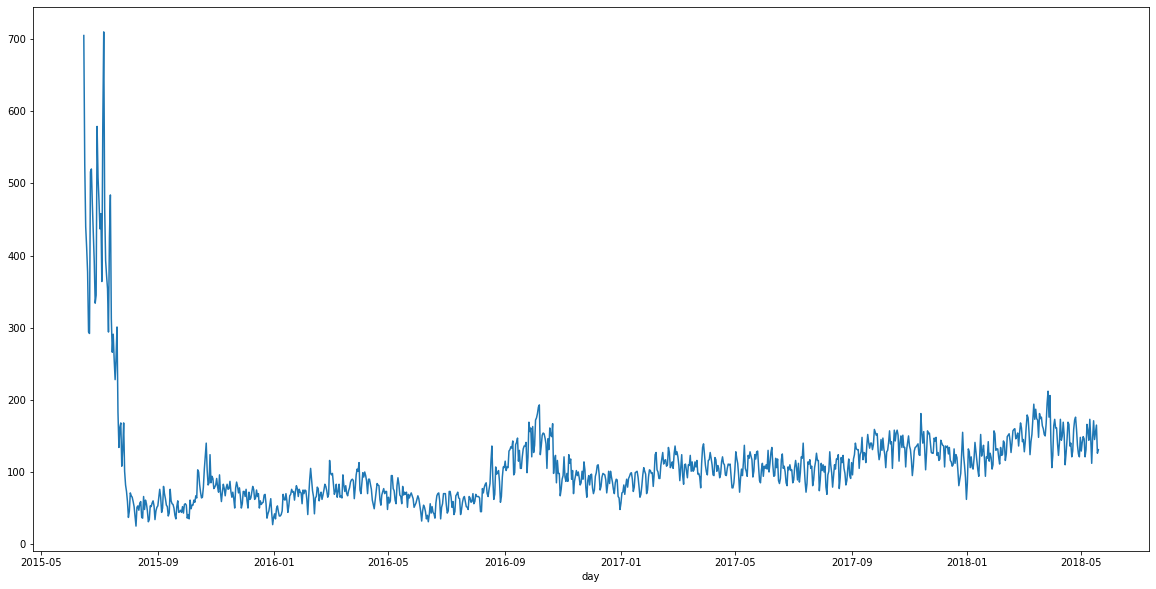

In [13]:
events_data.groupby(events_data.day).user_id.nunique().plot(figsize=(20,10))

<AxesSubplot:>

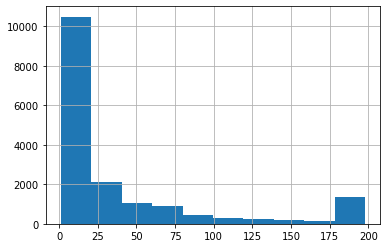

In [14]:
events_data[events_data.action == 'passed'].groupby('user_id', as_index=False).agg({'step_id': 'count'})\
.rename(columns={'step_id':'passed_steps'}).passed_steps.hist()

In [81]:
users_events_data = events_data.pivot_table(index='user_id',
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value = 0).reset_index()

In [16]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [17]:
user_score = submit_data.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc='count',
                       fill_value = 0).reset_index()
user_score

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [18]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [19]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

In [20]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

<AxesSubplot:>

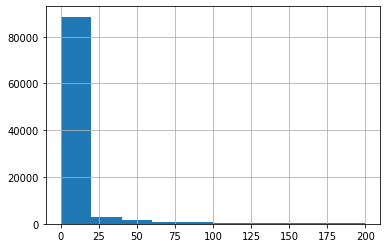

In [21]:
gap_data = gap_data / (24 * 60 * 60)
gap_data[gap_data < 200].hist()

In [22]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [23]:
users_data = events_data.groupby('user_id', as_index=False)\
.agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})


In [24]:
last_day = 1526772811
drop_out_threshhold = 2592000

In [25]:
users_data['is_gone_user'] = (last_day - users_data['last_timestamp']) > drop_out_threshhold
users_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [26]:
users_data = users_data.merge(user_score, how='outer')

In [27]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [28]:
users_data = users_data.fillna(0)

In [29]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [30]:
users_data = users_data.merge(users_events_data, how='outer')

In [31]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [32]:
users_day = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [33]:
users_day

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [34]:
users_data = users_data.merge(users_day, how='outer')

In [35]:
users_data.head(20)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
5,8,1481466913,True,9.0,21.0,109,84,37,156,2
6,9,1484999497,True,0.0,0.0,3,3,0,4,1
7,11,1526140625,False,0.0,0.0,1,0,1,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9,1
9,16,1513162585,True,77.0,106.0,196,196,108,651,21


In [36]:
users_data['passed_course'] = users_data.passed > 170


In [37]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


<AxesSubplot:>

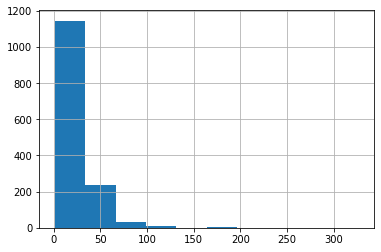

In [38]:
users_data[users_data.passed_course == True].day.hist()

In [39]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


In [40]:
user_min_time = events_data.groupby('user_id', as_index=False)\
.agg({'timestamp' : 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)

In [41]:
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [42]:
users_data = users_data.merge(user_min_time, how='outer')

In [43]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [44]:
users_data_train = pd.DataFrame()

In [45]:
events_data['user_time'] = events_data.user_id.map(str) + "_" + events_data.timestamp.map(str)


In [46]:
learning_time_threshold = 3*24*60*60
learning_time_threshold

259200

In [47]:
user_learning_time_threshold = user_min_time.user_id.map(str) + "_" + (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [48]:
events_data

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
...,...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19,11677_1526772685
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750


In [49]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [50]:
events_data.shape

(3480703, 8)

In [51]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [52]:
events_data_train

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [53]:
submit_data = pd.read_csv('submissions_data_train.csv')
submit_data['date'] = pd.to_datetime(submit_data.timestamp, unit='s')
submit_data['day'] = submit_data.date.dt.date

In [54]:
submit_data['user_time'] = submit_data.user_id.map(str) + "_" + submit_data.timestamp.map(str)
submit_data = submit_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submit_data_train = submit_data[submit_data.user_time <= submit_data.user_learning_time_threshold]
submit_data_train

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177
...,...,...,...,...,...,...,...,...
509099,120745.0,1.501947e+09,wrong,2615,2017-08-05 15:29:19,2017-08-05,2615_1501946959,2615_1502205860
509100,120745.0,1.503060e+09,correct,13177,2017-08-18 12:38:47,2017-08-18,13177_1503059927,13177_1503314487
509101,120745.0,1.506348e+09,wrong,15253,2017-09-25 14:02:33,2017-09-25,15253_1506348153,15253_1506606463
509102,120745.0,1.523035e+09,wrong,1424,2018-04-06 17:21:56,2018-04-06,1424_1523035316,1424_1523294469


In [55]:
X = submit_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [56]:
steps_tried = submit_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
    .rename(columns = {'step_id':'step_tried'})
steps_tried

,user_id,step_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23
...,...,...
8908,26787,3
8909,26790,1
8910,26794,27
8911,26797,2


In [57]:
X = X.merge(steps_tried,on='user_id')
X.head()

,user_id,days,step_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [58]:
X = X.merge(submit_data_train.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc='count',
                       fill_value = 0).reset_index())
X

,user_id,days,step_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [59]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value = 0).reset_index(), how='outer')
X

,user_id,days,step_tried,correct,wrong,discovered,passed,started_attempt,viewed
0,2,1.0,2.0,2.0,0.0,9,9,2,9
1,3,1.0,4.0,4.0,4.0,15,15,4,20
2,8,1.0,11.0,9.0,21.0,109,84,37,154
3,14,1.0,1.0,0.0,1.0,4,3,1,9
4,16,3.0,23.0,23.0,27.0,55,55,26,132
...,...,...,...,...,...,...,...,...,...
19229,26774,NaN,NaN,NaN,NaN,1,1,0,1
19230,26781,NaN,NaN,NaN,NaN,5,5,0,6
19231,26788,NaN,NaN,NaN,NaN,1,1,0,1
19232,26789,NaN,NaN,NaN,NaN,2,2,0,2


In [60]:
X = X.fillna(0)

In [61]:
data = X.merge(users_data[['user_id','passed_course']], how='outer')
data

,user_id,days,step_tried,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,2,1.0,2.0,2.0,0.0,9,9,2,9,False
1,3,1.0,4.0,4.0,4.0,15,15,4,20,False
2,8,1.0,11.0,9.0,21.0,109,84,37,154,False
3,14,1.0,1.0,0.0,1.0,4,3,1,9,False
4,16,3.0,23.0,23.0,27.0,55,55,26,132,True
...,...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,1,1,0,1,False
19230,26781,0.0,0.0,0.0,0.0,5,5,0,6,True
19231,26788,0.0,0.0,0.0,0.0,1,1,0,1,False
19232,26789,0.0,0.0,0.0,0.0,2,2,0,2,False


In [65]:
X = data.drop(['passed_course'], axis=1)
y = data.passed_course.map(int)

In [66]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [64]:
clf = RandomForestClassifier()

In [4]:
paramaters = {'n_estimators' : range(10, 50, 10),
             'max_depth' : range(1, 12, 2),
             'min_samples_leaf' : range(1, 7),
             'min_samples_split' : range(2, 9, 2)}

In [5]:
grid_cv = GridSearchCV(clf, param_grid=paramaters, cv=5, n_jobs=-1)

In [82]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 12, 2),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(2, 9, 2),
                         'n_estimators': range(10, 50, 10)})

In [83]:
grid_cv.best_params_

{'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 20}

In [84]:
best_clf = grid_cv.best_estimator_
best_clf.score(X_test, y_test)

0.9291115311909263

In [85]:
y_predicted_prob = best_clf.predict_proba(X_test)[:,1]
y_predicted_prob

array([0.0535819 , 0.0491527 , 0.06832847, ..., 0.23841341, 0.09384221,
       0.0230359 ])

In [87]:
roc_auc_score(y_test, y_predicted_prob)

0.8398550189027416

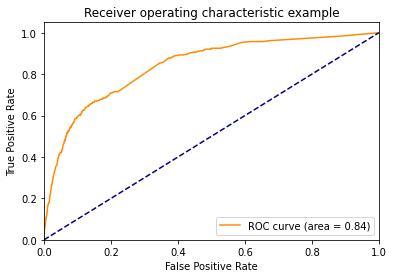

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [90]:
result = pd.DataFrame(data={'user_id':X_test.index, 'is_gone':y_predicted_prob})
result.head()

,user_id,is_gone
0,200,0.053582
1,9760,0.049153
2,2255,0.068328
3,7066,0.061924
4,10001,0.013092


In [91]:
result.to_csv('output.csv', index=False)